# Facial Keypoint Detection in Tensorflow 2 using CNNs

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from PIL import Image

tf.keras.backend.clear_session()
%matplotlib notebook

## Load Faces and Landmarks

In [95]:
faces_dir = Path('./faces')

In [96]:
landmarks_path = faces_dir/'face_landmarks.csv'

In [97]:
landmarks_df = pd.read_csv(landmarks_path)

In [98]:
landmarks_df.head()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


In [99]:
landmarks_df.columns

Index(['image_name', 'part_0_x', 'part_0_y', 'part_1_x', 'part_1_y',
       'part_2_x', 'part_2_y', 'part_3_x', 'part_3_y', 'part_4_x',
       ...
       'part_63_x', 'part_63_y', 'part_64_x', 'part_64_y', 'part_65_x',
       'part_65_y', 'part_66_x', 'part_66_y', 'part_67_x', 'part_67_y'],
      dtype='object', length=137)

In [100]:
def show_landmarks(image, landmarks):
    plt.figure()
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')

In [101]:
def get_landmarks(df):
    landmarks = df.iloc[:, 1:].values
    landmarks = landmarks.reshape(landmarks.shape[0],-1, 2)
    return landmarks

<IPython.core.display.Javascript object>


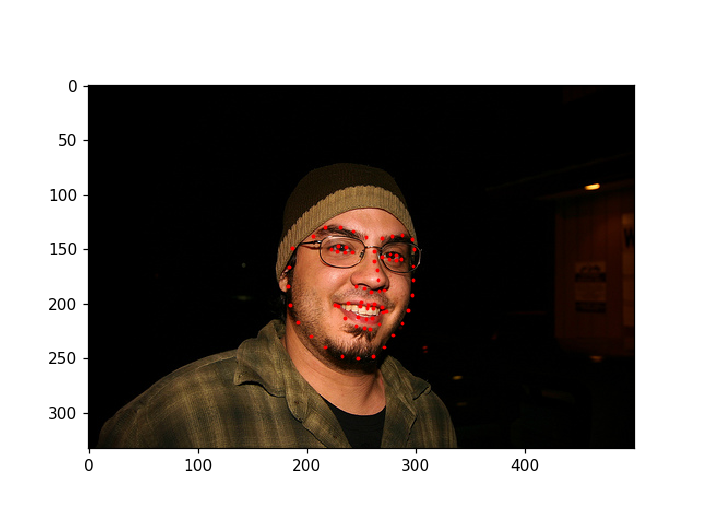

In [102]:
random_idx = np.random.randint(0, len(landmarks_df))
landmarks = get_landmarks(landmarks_df)
show_landmarks(Image.open(faces_dir/landmarks_df.loc[random_idx, 'image_name']),
               landmarks[random_idx])

In [106]:
landmarks_df['image_name'] = str(faces_dir) + '/' + landmarks_df['image_name']

In [107]:
image_paths, landmarks = landmarks_df['image_name'].values , get_landmarks(landmarks_df)

In [108]:
image_paths.shape, landmarks.shape

((69,), (69, 68, 2))

In [109]:
train_img_paths, val_img_paths, train_landmarks, val_landmarks = train_test_split(image_paths, landmarks, test_size=0.1,
                                                                                  random_state=0)

In [110]:
val_img_paths.shape

(7,)

## Preprocessing 
- Normalization
- Resizing
- Random Saturation
- Random Horizontal Flip

In [739]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BUFFER_SIZE = 64
BATCH_SIZE = 32
NUM_KEYPOINTS = 68

In [768]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    return img

In [769]:
#Normalize image to [0, 1]
#Normalize landmarks to [0, 1]
def normalize(img, landmarks):
    h, w = tf.shape(img)[0], tf.shape(img)[1]
    h, w = tf.cast(h, tf.float32), tf.cast(w, tf.float32)
    img /= 255.0
    #landmarks = tf.stack([landmarks[:, 0] / w, landmarks[:, 1] / h], axis=-1)
    landmarks /= [w, h]
    landmarks = tf.reshape(landmarks, (-1, ))
    return img, landmarks

In [770]:
def resize(img, landmarks, new_size=(IMG_HEIGHT, IMG_WIDTH)):
    h, w = tf.shape(img)[0], tf.shape(img)[1]
    new_h, new_w = new_size
    img = tf.image.resize(img, [new_h, new_w], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    #Note that for the landmarks, x-axis is width, while y-axis is height
    ratios = [new_w / w, new_h / h]
    #ratios = tf.cast(tf.stack([new_w / w, new_h / h]), dtype=tf.float32)
    landmarks = landmarks * ratios
    return img, landmarks

In [771]:
def random_saturation(img, landmarks, lower=1, upper=2):
    img = tf.image.random_saturation(img, lower, upper)
    return img, landmarks

In [772]:
def random_flip_left_right(img, landmarks):
    if tf.random.normal(shape=()) > 0.5:
        img = tf.image.flip_left_right(img)
        w = tf.shape(img)[1]
        w = tf.cast(w, tf.float32)
        landmarks = tf.stack([w - landmarks[:, 0], landmarks[:, 1]], axis=-1)
    return img, landmarks

In [773]:
def preprocess_train(img_path, landmarks):
    img = load_image(img_path)
    landmarks = tf.cast(landmarks, tf.float32)
    img, landmarks = resize(img, landmarks)
    img, landmarks = random_saturation(img, landmarks)
    img, landmarks = random_flip_left_right(img, landmarks)
    
    img, landmarks = normalize(img, landmarks)
    return img, landmarks

In [774]:
def preprocess_val(img_path, landmarks):
    img = load_image(img_path)
    landmarks = tf.cast(landmarks, tf.float32)
    img, landmarks = resize(img, landmarks)
    img, landmarks = normalize(img, landmarks)
    return img, landmarks

In [775]:
def convert_back(img, landmarks):
    img = tf.cast(img*255, tf.uint8)
    h, w = img.shape[0], img.shape[1]
    landmarks = tf.reshape(landmarks, (-1, 2))
    landmarks *= [w, h]
    return img, landmarks

## Define tf.Data

In [776]:
train_data = tf.data.Dataset.from_tensor_slices((train_img_paths, train_landmarks))
train_data = train_data.map(preprocess_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 136)), types: (tf.float32, tf.float32)>

<IPython.core.display.Javascript object>


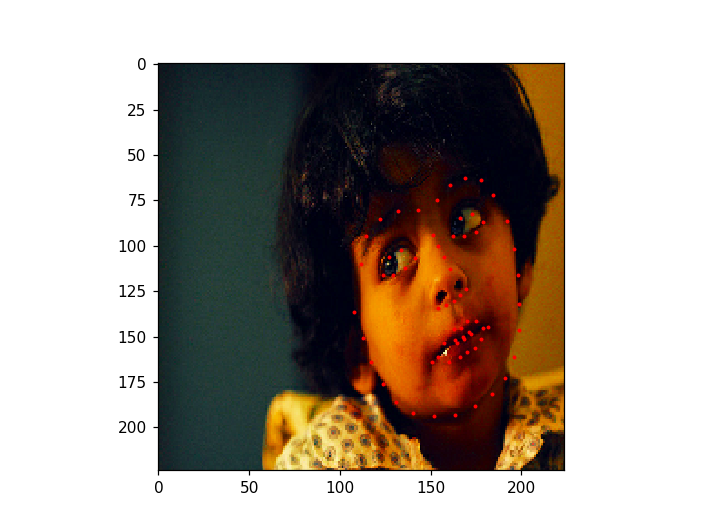

In [790]:
for images, landmarks in train_data.take(1):
    show_landmarks(*convert_back(images[0], landmarks[0]))

In [735]:
val_data = tf.data.Dataset.from_tensor_slices((val_img_paths, val_landmarks))
val_data = val_data.map(preprocess_val, num_parallel_calls = tf.data.experimental.AUTOTUNE)
val_data = val_data.batch(BATCH_SIZE)

## Define and Train a custom CNN

In [753]:
model = keras.Sequential([
    keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    keras.layers.Conv2D(16, 3, strides=2, padding='same', activation='relu'), #(112, 112, 16)
    keras.layers.MaxPool2D(), #(64, 64, 16)
    keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'), #(32, 32, 64)
    keras.layers.MaxPool2D(), #(16, 16, 64)
    keras.layers.Conv2D(128, 3, strides=2, padding='same', activation='relu'), #(8, 8, 128)
    keras.layers.Conv2D(256, 3, strides=2, padding='same', activation='relu'), #(8, 8, 128)
    keras.layers.GlobalAveragePooling2D(), #(1, 1, 128)
    keras.layers.Dense(NUM_KEYPOINTS * 2, activation='sigmoid'),
], name='KeypointDetector')

In [754]:
model.summary()

Model: "KeypointDetector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 112, 112, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        9280      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 256)          

In [755]:
model.compile(optimizer='adam', loss=keras.losses.Huber())

In [756]:
history = model.fit(train_data, validation_data=val_data, epochs=500)

Train for 2 steps, validate for 1 steps
Epoch 1/500
2/2 [==============================] - 2s 868ms/step - loss: 0.0145 - val_loss: 0.0084
Epoch 2/500
2/2 [==============================] - 0s 156ms/step - loss: 0.0138 - val_loss: 0.0072
Epoch 3/500
2/2 [==============================] - 0s 164ms/step - loss: 0.0127 - val_loss: 0.0058
Epoch 4/500
2/2 [==============================] - 0s 155ms/step - loss: 0.0112 - val_loss: 0.0063
Epoch 5/500
2/2 [==============================] - 0s 152ms/step - loss: 0.0113 - val_loss: 0.0053
Epoch 6/500
2/2 [==============================] - 0s 155ms/step - loss: 0.0111 - val_loss: 0.0051
Epoch 7/500
2/2 [==============================] - 0s 163ms/step - loss: 0.0105 - val_loss: 0.0051
Epoch 8/500
2/2 [==============================] - 0s 158ms/step - loss: 0.0104 - val_loss: 0.0049
Epoch 9/500
2/2 [==============================] - 0s 160ms/step - loss: 0.0105 - val_loss: 0.0049
Epoch 10/500
2/2 [==============================] - 0s 157ms/step - l

2/2 [==============================] - 0s 161ms/step - loss: 0.0088 - val_loss: 0.0041
Epoch 83/500
2/2 [==============================] - 0s 154ms/step - loss: 0.0095 - val_loss: 0.0041
Epoch 84/500
2/2 [==============================] - 0s 151ms/step - loss: 0.0084 - val_loss: 0.0045
Epoch 85/500
2/2 [==============================] - 0s 152ms/step - loss: 0.0090 - val_loss: 0.0041
Epoch 86/500
2/2 [==============================] - 0s 167ms/step - loss: 0.0091 - val_loss: 0.0043
Epoch 87/500
2/2 [==============================] - 0s 153ms/step - loss: 0.0097 - val_loss: 0.0042
Epoch 88/500
2/2 [==============================] - 0s 152ms/step - loss: 0.0091 - val_loss: 0.0044
Epoch 89/500
2/2 [==============================] - 0s 176ms/step - loss: 0.0087 - val_loss: 0.0045
Epoch 90/500
2/2 [==============================] - 0s 160ms/step - loss: 0.0088 - val_loss: 0.0047
Epoch 91/500
2/2 [==============================] - 0s 164ms/step - loss: 0.0090 - val_loss: 0.0047
Epoch 92/500


2/2 [==============================] - 0s 169ms/step - loss: 0.0044 - val_loss: 0.0055
Epoch 164/500
2/2 [==============================] - 0s 159ms/step - loss: 0.0052 - val_loss: 0.0058
Epoch 165/500
2/2 [==============================] - 0s 175ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 166/500
2/2 [==============================] - 0s 190ms/step - loss: 0.0053 - val_loss: 0.0067
Epoch 167/500
2/2 [==============================] - 0s 178ms/step - loss: 0.0051 - val_loss: 0.0072
Epoch 168/500
2/2 [==============================] - 0s 167ms/step - loss: 0.0050 - val_loss: 0.0070
Epoch 169/500
2/2 [==============================] - 0s 205ms/step - loss: 0.0047 - val_loss: 0.0071
Epoch 170/500
2/2 [==============================] - 0s 183ms/step - loss: 0.0046 - val_loss: 0.0066
Epoch 171/500
2/2 [==============================] - 0s 174ms/step - loss: 0.0051 - val_loss: 0.0066
Epoch 172/500
2/2 [==============================] - 0s 177ms/step - loss: 0.0047 - val_loss: 0.0067
Epoc

2/2 [==============================] - 0s 162ms/step - loss: 0.0012 - val_loss: 0.0110
Epoch 245/500
2/2 [==============================] - 0s 158ms/step - loss: 0.0011 - val_loss: 0.0104
Epoch 246/500
2/2 [==============================] - 0s 156ms/step - loss: 0.0012 - val_loss: 0.0119
Epoch 247/500
2/2 [==============================] - 0s 156ms/step - loss: 0.0010 - val_loss: 0.0097
Epoch 248/500
2/2 [==============================] - 0s 157ms/step - loss: 0.0010 - val_loss: 0.0123
Epoch 249/500
2/2 [==============================] - 0s 156ms/step - loss: 0.0013 - val_loss: 0.0108
Epoch 250/500
2/2 [==============================] - 0s 155ms/step - loss: 0.0011 - val_loss: 0.0106
Epoch 251/500
2/2 [==============================] - 0s 155ms/step - loss: 8.8184e-04 - val_loss: 0.0100
Epoch 252/500
2/2 [==============================] - 0s 155ms/step - loss: 0.0011 - val_loss: 0.0122
Epoch 253/500
2/2 [==============================] - 0s 155ms/step - loss: 9.5153e-04 - val_loss: 0.0

2/2 [==============================] - 0s 157ms/step - loss: 2.4766e-04 - val_loss: 0.0117
Epoch 323/500
2/2 [==============================] - 0s 153ms/step - loss: 2.9272e-04 - val_loss: 0.0115
Epoch 324/500
2/2 [==============================] - 0s 156ms/step - loss: 2.7414e-04 - val_loss: 0.0118
Epoch 325/500
2/2 [==============================] - 0s 155ms/step - loss: 2.5381e-04 - val_loss: 0.0115
Epoch 326/500
2/2 [==============================] - 0s 152ms/step - loss: 2.4817e-04 - val_loss: 0.0124
Epoch 327/500
2/2 [==============================] - 0s 152ms/step - loss: 2.3032e-04 - val_loss: 0.0112
Epoch 328/500
2/2 [==============================] - 0s 153ms/step - loss: 2.1287e-04 - val_loss: 0.0118
Epoch 329/500
2/2 [==============================] - 0s 152ms/step - loss: 2.2965e-04 - val_loss: 0.0115
Epoch 330/500
2/2 [==============================] - 0s 152ms/step - loss: 2.3457e-04 - val_loss: 0.0117
Epoch 331/500
2/2 [==============================] - 0s 152ms/step - 

2/2 [==============================] - 0s 153ms/step - loss: 1.1342e-04 - val_loss: 0.0110
Epoch 401/500
2/2 [==============================] - 0s 160ms/step - loss: 1.1751e-04 - val_loss: 0.0117
Epoch 402/500
2/2 [==============================] - 0s 167ms/step - loss: 1.0864e-04 - val_loss: 0.0110
Epoch 403/500
2/2 [==============================] - 0s 152ms/step - loss: 1.4789e-04 - val_loss: 0.0122
Epoch 404/500
2/2 [==============================] - 0s 150ms/step - loss: 1.3689e-04 - val_loss: 0.0106
Epoch 405/500
2/2 [==============================] - 0s 152ms/step - loss: 1.5420e-04 - val_loss: 0.0120
Epoch 406/500
2/2 [==============================] - 0s 153ms/step - loss: 1.1796e-04 - val_loss: 0.0113
Epoch 407/500
2/2 [==============================] - 0s 155ms/step - loss: 1.1735e-04 - val_loss: 0.0114
Epoch 408/500
2/2 [==============================] - 0s 158ms/step - loss: 1.3688e-04 - val_loss: 0.0118
Epoch 409/500
2/2 [==============================] - 0s 160ms/step - 

2/2 [==============================] - 0s 153ms/step - loss: 8.1241e-05 - val_loss: 0.0110
Epoch 479/500
2/2 [==============================] - 0s 154ms/step - loss: 7.0650e-05 - val_loss: 0.0114
Epoch 480/500
2/2 [==============================] - 0s 152ms/step - loss: 6.3444e-05 - val_loss: 0.0109
Epoch 481/500
2/2 [==============================] - 0s 155ms/step - loss: 7.1058e-05 - val_loss: 0.0111
Epoch 482/500
2/2 [==============================] - 0s 158ms/step - loss: 6.5420e-05 - val_loss: 0.0112
Epoch 483/500
2/2 [==============================] - 0s 156ms/step - loss: 6.8878e-05 - val_loss: 0.0109
Epoch 484/500
2/2 [==============================] - 0s 160ms/step - loss: 6.1211e-05 - val_loss: 0.0114
Epoch 485/500
2/2 [==============================] - 0s 160ms/step - loss: 7.4394e-05 - val_loss: 0.0108
Epoch 486/500
2/2 [==============================] - 0s 160ms/step - loss: 7.7680e-05 - val_loss: 0.0114
Epoch 487/500
2/2 [==============================] - 0s 154ms/step - 

<IPython.core.display.Javascript object>


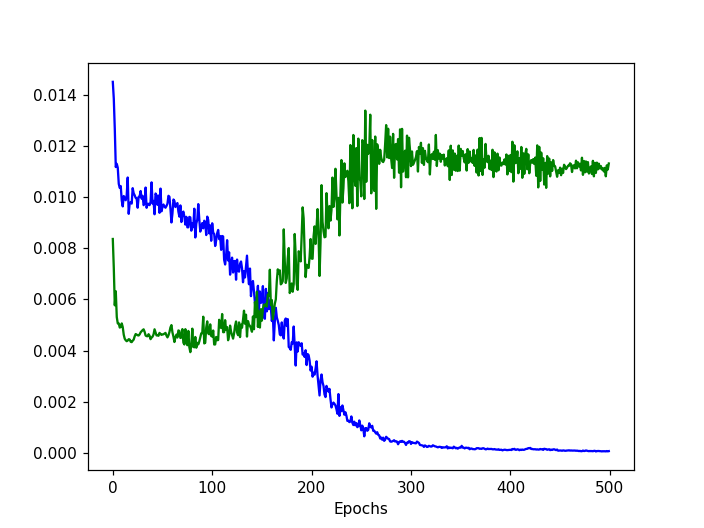

In [758]:
train_loss, val_loss = history.history['loss'], history.history['val_loss']
plt.figure()
plt.plot(train_loss, 'b-')
plt.plot(val_loss, 'g-')
plt.xlabel('Epochs')
plt.show()

## Evaluate Model

In [759]:
def show_predictions_on_batch(images, predictions):
    n = images.shape[0]
    for i in range(n):
        show_landmarks(*convert_back(images[i], predictions[i]))

<IPython.core.display.Javascript object>


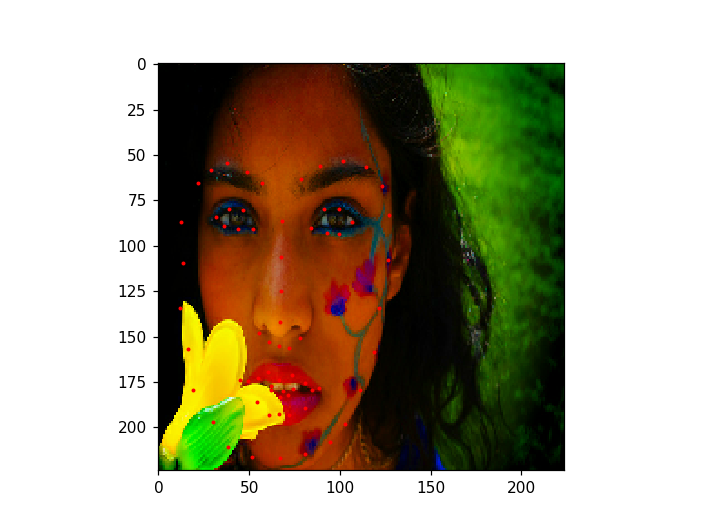

<IPython.core.display.Javascript object>


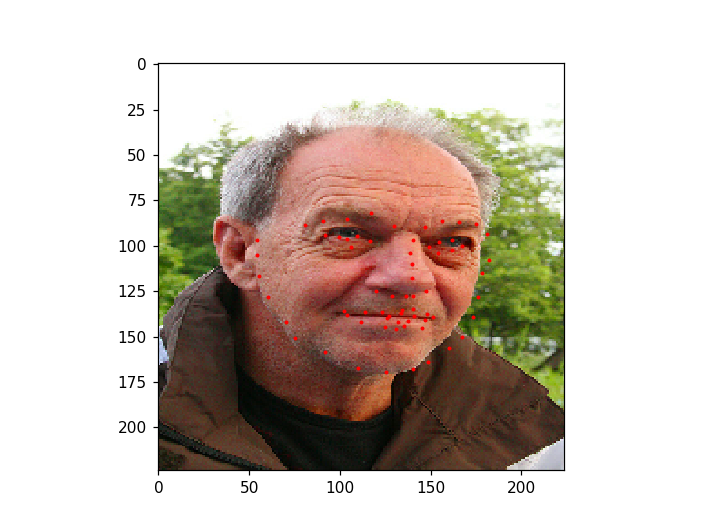

<IPython.core.display.Javascript object>


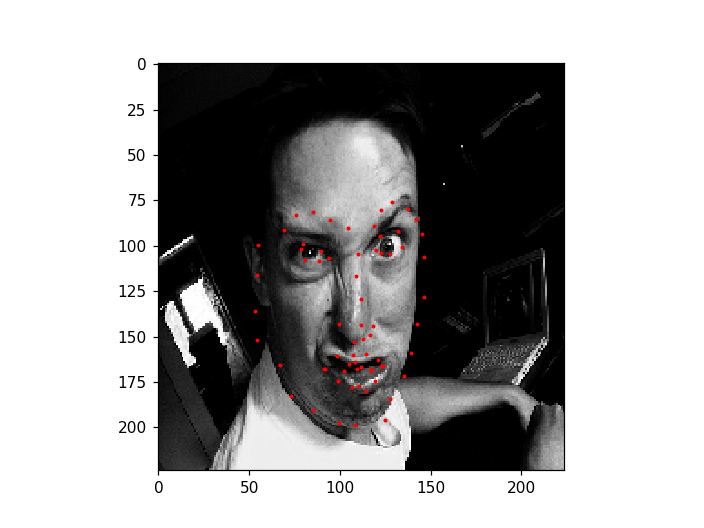

<IPython.core.display.Javascript object>


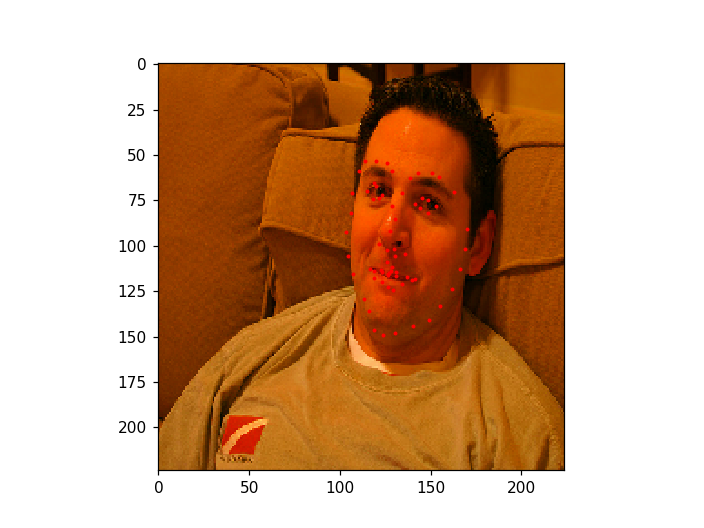

<IPython.core.display.Javascript object>


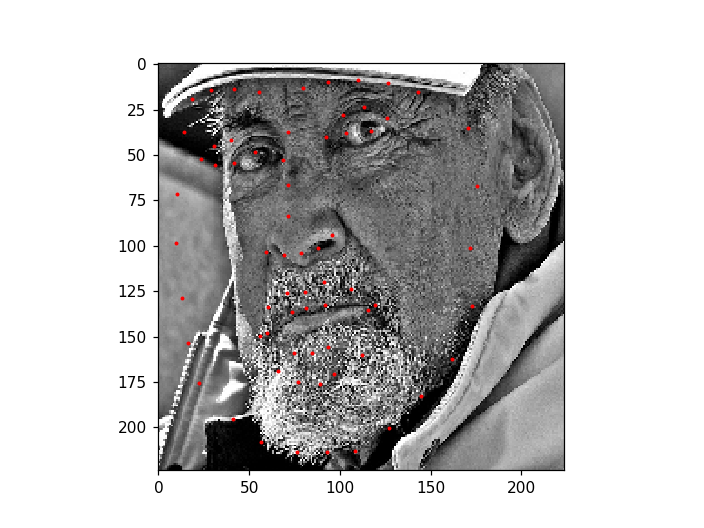

In [761]:
for images, landmarks in train_data.take(1):
    show_predictions_on_batch(images[:5], model.predict_on_batch(images[:5]))